In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
path = os.getcwd()
url = os.path.join(path, "UAV_4_Data_down_CleanedFinal.xlsx")
data = pd.read_excel(url, sheet_name=["Sheet1", "Sheet2", "Sheet3", "Sheet4", "Sheet5"])

In [2]:
vehicle_data = pd.concat([data['Sheet1'], data['Sheet2']])
vehicle_data = pd.concat([vehicle_data, data['Sheet3']])
vehicle_data = pd.concat([vehicle_data, data['Sheet4']])
vehicle_data = pd.concat([vehicle_data, data['Sheet5']])

normalized_data = (vehicle_data - np.min(vehicle_data)) / (np.max(vehicle_data) - np.min(vehicle_data))

c:\users\konos\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\users\konos\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
c:\users\konos\appdata\local\programs\python\python39\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axi

In [3]:
column_indices = {name: i for i, name in enumerate(normalized_data.columns)}

n = len(normalized_data)
train_df = normalized_data[0:int(n*0.7)]
val_df = normalized_data[int(n*0.7):int(n*0.9)]
test_df = normalized_data[int(n*0.9):]

num_features = normalized_data.shape[1]
column_indices = {name: i for i, name in enumerate(normalized_data.columns)}

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='Speed(m/s)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [0.0333 seconds]')

WindowGenerator.plot = plot

def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [4]:
WindowGenerator.split_window = split_window
WindowGenerator.plot = plot
WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [5]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [6]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [7]:
val_performance = {}
performance = {}

In [8]:
CONV_WIDTH = 50
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Speed(m/s)'])

print(conv_window)

# Create Multi-Step Dense Model
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),])

# Down-side: can only be executed on input windows of exactly this shape
print('\nInput shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape, '\n')

'''
# Train Multi-Step Dense Model 
history = compile_and_fit(multi_step_dense, conv_window)
# IPython.display.clear_output()

# Evaluate Multi-Step Dense Model
val_performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi Step Dense CW'] = multi_step_dense.evaluate(conv_window.test, verbose=0)
print("\nPerformance:", performance['Multi Step Dense CW'], 
      "Val Performance:", val_performance['Multi Step Dense CW'])

# Plot Multi-Step Dense Model
conv_window.plot(multi_step_dense)
'''

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50]
Label column name(s): ['Speed(m/s)']

Input shape: (32, 50, 11)
Output shape: (32, 1, 1) 



'\n# Train Multi-Step Dense Model \nhistory = compile_and_fit(multi_step_dense, conv_window)\n# IPython.display.clear_output()\n\n# Evaluate Multi-Step Dense Model\nval_performance[\'Multi Step Dense CW\'] = multi_step_dense.evaluate(conv_window.val)\nperformance[\'Multi Step Dense CW\'] = multi_step_dense.evaluate(conv_window.test, verbose=0)\nprint("\nPerformance:", performance[\'Multi Step Dense CW\'], \n      "Val Performance:", val_performance[\'Multi Step Dense CW\'])\n\n# Plot Multi-Step Dense Model\nconv_window.plot(multi_step_dense)\n'

In [9]:

# Convolution Neural Network
# Same as the dense model except Flatten and first dense are replaced by Conv1D 
# Reshape is no longer necessary since convolution keeps time axis in output
# Conv_models can be run on inputs of any length, multi-step dense cannot
print(conv_window)

# Create CNN
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),])

print("\nConv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape, '\n')

'''
# Train CNN
history = compile_and_fit(conv_model, conv_window)
# IPython.display.clear_output()

# Evaluate CNN
val_performance['Conv CW'] = conv_model.evaluate(conv_window.val)
performance['Conv CW'] = conv_model.evaluate(conv_window.test, verbose=0)
print("\nPerformance:", performance['Conv CW'], 
      "Val Performance:", val_performance['Conv CW'])

# Plot CNN
conv_window.plot(conv_model)

# Save CNN
'''

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50]
Label column name(s): ['Speed(m/s)']

Conv model on `conv_window`
Input shape: (32, 50, 11)
Output shape: (32, 1, 1) 



'\n# Train CNN\nhistory = compile_and_fit(conv_model, conv_window)\n# IPython.display.clear_output()\n\n# Evaluate CNN\nval_performance[\'Conv CW\'] = conv_model.evaluate(conv_window.val)\nperformance[\'Conv CW\'] = conv_model.evaluate(conv_window.test, verbose=0)\nprint("\nPerformance:", performance[\'Conv CW\'], \n      "Val Performance:", val_performance[\'Conv CW\'])\n\n# Plot CNN\nconv_window.plot(conv_model)\n\n# Save CNN\n'

In [10]:
# Output is shorter than input to train/plot, we need labels and prediction 
# to have same length
# WindowGenerator produces wide windows with extra input time steps so
# the label/prediction lengths match

# Makes 50 time step predictions, given 99 (100 - 1) time step of history
LABEL_WIDTH = 50
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)

wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Speed(m/s)'])

wide_conv_window

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): ['Speed(m/s)']

In [11]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 99, 11)
Labels shape: (32, 50, 1)
Output shape: (32, 50, 1)


In [12]:
'''
wide_conv_window.plot(conv_model)
'''

'\nwide_conv_window.plot(conv_model)\n'

Total window size: 51
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Label column name(s): ['Speed(m/s)']

Input shape: (32, 50, 11)
Output shape: (32, 50, 1) 

Epoch 1/20
32632/32632 [==============================] - 206s 6ms/step - loss: 2.3429e-05 - mean_absolute_error: 7.9251e-04 - val_loss: 2.3005e-05 - val_mean_absolute_error: 3.6739e-04
Epoch 2/20
32632/32632 [==============================] - 207s 6ms/step - loss: 1.9580e-05 - mean_absolute_error: 3.7790e-04 - val_loss: 2.2944e-05 - val_mean_absolute_error: 3.0693e-04
Epoch 3/20
32632/32632 [==============================] - 207s 6ms/step - loss: 1.9499e-05 - mean_absolute_error: 3.0837e-04 - val_loss: 2.2958e-05 - val_mean_absolute_error: 3

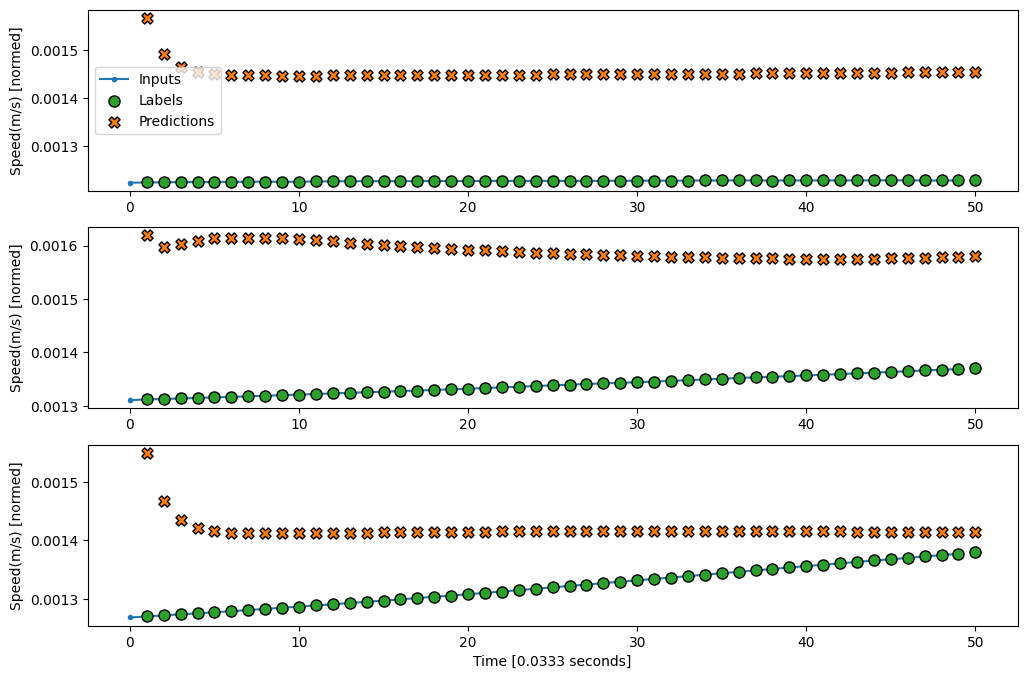

In [13]:
# Recurrent Neural Network
# Well suited for time series data, process a time series step-by-step
# maintaining an internal state from time-step to time-step


# Random Note
# return_sequence = false, default, layer only returns output of final time step
# giving model time to warm up internal state before making single prediction
# return_sequence = true, layer returns outfor for each input
# useful for stacking RNN layers, training model on multiple time steps simultaneously

# Long Short Term Memory Model

# This generates 50 time steps of consecutive inputs and labels at a time
# This doesn't change the way the model operates.
# Still makes 1 time step predictions, given 1 time step of history
# each prediction is made independently
wide_window = WindowGenerator(
    input_width=50, 
    label_width=50, 
    shift=1, 
    label_columns=['Speed(m/s)'])

print(wide_window)

# Create LSTM Model
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # return_sequences = true, model can be trained on 24 hours of data at a time
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)])

print('\nInput shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape, '\n')

# Train LSTM Model
history = compile_and_fit(lstm_model, wide_window)
# IPython.display.clear_output()

# Evaluate LSTM Model
val_performance['LSTM WW'] = lstm_model.evaluate(wide_window.val)
performance['LSTM WW'] = lstm_model.evaluate(wide_window.test, verbose=0)
print("\nPerformance:", performance['LSTM WW'], 
      "Val Performance:", val_performance['LSTM WW'])

# Plot LSTM Model
wide_window.plot(lstm_model)

LSTM WW     : 0.0004



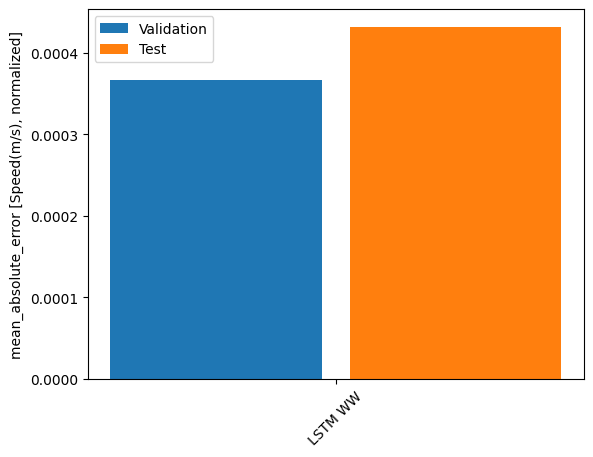

In [14]:
# Performance comparison of each model
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

print()

x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Speed(m/s), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [15]:
# These models perform worse than the single step predictions.


# Multi-Step Models
# These models will make multiple time step predictions instead of 1 time step

# Initialize dict to store performance values
multi_val_performance = {}
multi_performance = {}

# Baseline
# Repeats last input time step for required number of output time steps
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

# Makes 50 time step predictions, given 50 time step of history
OUT_STEPS = 50
multi_window = WindowGenerator(
    input_width=50, 
    label_width=OUT_STEPS, 
    shift=OUT_STEPS)

'''
print(multi_window)

# Create Baseline Model
last_baseline = MultiStepLastBaseline()

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', last_baseline(multi_window.example[0]).shape, '\n')


# Train Baseline Model
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Evaluate Baseline Model
multi_val_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last Baseline MW'] = last_baseline.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Last Baseline MW'], 
      "Val Performance:", multi_val_performance['Last Baseline MW'])

# Plot Baseline Model
multi_window.plot(last_baseline)
'''

'\nprint(multi_window)\n\n# Create Baseline Model\nlast_baseline = MultiStepLastBaseline()\n\nprint(\'\nInput shape:\', multi_window.example[0].shape)\nprint(\'Output shape:\', last_baseline(multi_window.example[0]).shape, \'\n\')\n\n\n# Train Baseline Model\nlast_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),\n                      metrics=[tf.keras.metrics.MeanAbsoluteError()])\n\n# Evaluate Baseline Model\nmulti_val_performance[\'Last Baseline MW\'] = last_baseline.evaluate(multi_window.val)\nmulti_performance[\'Last Baseline MW\'] = last_baseline.evaluate(multi_window.test, verbose=0)\nprint("\nPerformance:", multi_performance[\'Last Baseline MW\'], \n      "Val Performance:", multi_val_performance[\'Last Baseline MW\'])\n\n# Plot Baseline Model\nmulti_window.plot(last_baseline)\n'

In [16]:
# Repeat Baseline
# Repeats the previous day, assuming tomorrow will be similar
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

'''
print(multi_window)

# Create Repeat Baseline Model
repeat_baseline = RepeatBaseline()

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', last_baseline(multi_window.example[0]).shape, '\n')

# Train Repeat Baseline Model
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

# Evaluate Repeat Baseline Model
multi_val_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat Baseline MW'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Repeat Baseline MW'], 
      "Val Performance:", multi_val_performance['Repeat Baseline MW'])

# Plot Repeat Baseline Model
multi_window.plot(repeat_baseline)
'''

'\nprint(multi_window)\n\n# Create Repeat Baseline Model\nrepeat_baseline = RepeatBaseline()\n\nprint(\'\nInput shape:\', multi_window.example[0].shape)\nprint(\'Output shape:\', last_baseline(multi_window.example[0]).shape, \'\n\')\n\n# Train Repeat Baseline Model\nrepeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),\n                        metrics=[tf.keras.metrics.MeanAbsoluteError()])\n\n# Evaluate Repeat Baseline Model\nmulti_val_performance[\'Repeat Baseline MW\'] = repeat_baseline.evaluate(multi_window.val)\nmulti_performance[\'Repeat Baseline MW\'] = repeat_baseline.evaluate(multi_window.test, verbose=0)\nprint("\nPerformance:", multi_performance[\'Repeat Baseline MW\'], \n      "Val Performance:", multi_val_performance[\'Repeat Baseline MW\'])\n\n# Plot Repeat Baseline Model\nmulti_window.plot(repeat_baseline)\n'

In [17]:
'''
# Single Shot Models
# Makes entire sequence prediction in single step

# Multi Linear Model
print(multi_window)

# Create Multi Linear Model
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_linear_model(multi_window.example[0]).shape, '\n')

# Train Multi Linear Model
history = compile_and_fit(multi_linear_model, multi_window)
# IPython.display.clear_output()

# Evaluate Multi Linear Model
multi_val_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Single Shot Multi Linear MW'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
print("\nPerformance:", multi_performance['Single Shot Multi Linear MW'], 
      "Val Performance:", multi_val_performance['Single Shot Multi Linear MW'])

# Plot Multi Linear Model
multi_window.plot(multi_linear_model)
'''

'\n# Single Shot Models\n# Makes entire sequence prediction in single step\n\n# Multi Linear Model\nprint(multi_window)\n\n# Create Multi Linear Model\nmulti_linear_model = tf.keras.Sequential([\n    # Take the last time-step.\n    # Shape [batch, time, features] => [batch, 1, features]\n    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),\n    # Shape => [batch, 1, out_steps*features]\n    tf.keras.layers.Dense(OUT_STEPS*num_features,\n                          kernel_initializer=tf.initializers.zeros()),\n    # Shape => [batch, out_steps, features]\n    tf.keras.layers.Reshape([OUT_STEPS, num_features])])\n\nprint(\'\nInput shape:\', multi_window.example[0].shape)\nprint(\'Output shape:\', multi_linear_model(multi_window.example[0]).shape, \'\n\')\n\n# Train Multi Linear Model\nhistory = compile_and_fit(multi_linear_model, multi_window)\n# IPython.display.clear_output()\n\n# Evaluate Multi Linear Model\nmulti_val_performance[\'Single Shot Multi Linear MW\'] = multi_linear_model.evalua

In [18]:
# Autoregressive Model
# Decomposes prediction into individual time steps, feeds output back into 
# itself at each step and prediction can be conditioned to the previous one

# Any single step multi-output model can be fed into an Autoregreesive loop
# Recurrent Neural Network is explicitly trained to do this though

# Model must manage inputs for each step
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

# Model requires a "warmup" to initialize internal state based on inputs
# equivalent to Single Step LSTM model from above
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

# Iterates the model feeding the predictions at each step back as input
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 11)
Output shape: (32, 50, 11) 

Epoch 1/20
32631/32631 [==============================] - 216s 7ms/step - loss: 0.0071 - mean_absolute_error: 0.0466 - val_loss: 0.0040 - val_mean_absolute_error: 0.0279
Epoch 2/20
32631/32631 [==============================] - 214s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0419 - val_loss: 0.0040 - val_mean_absolute_error: 0.0257
Epoch 3/20
32631/32631 [==============================] - 214s 7ms/step - loss: 0.0055 - mean_absolute_error: 0.0417 - val_loss: 0.0038 - val_mean_absolute_error: 0.0257
Epoch 4/20
32631/32631 [======================

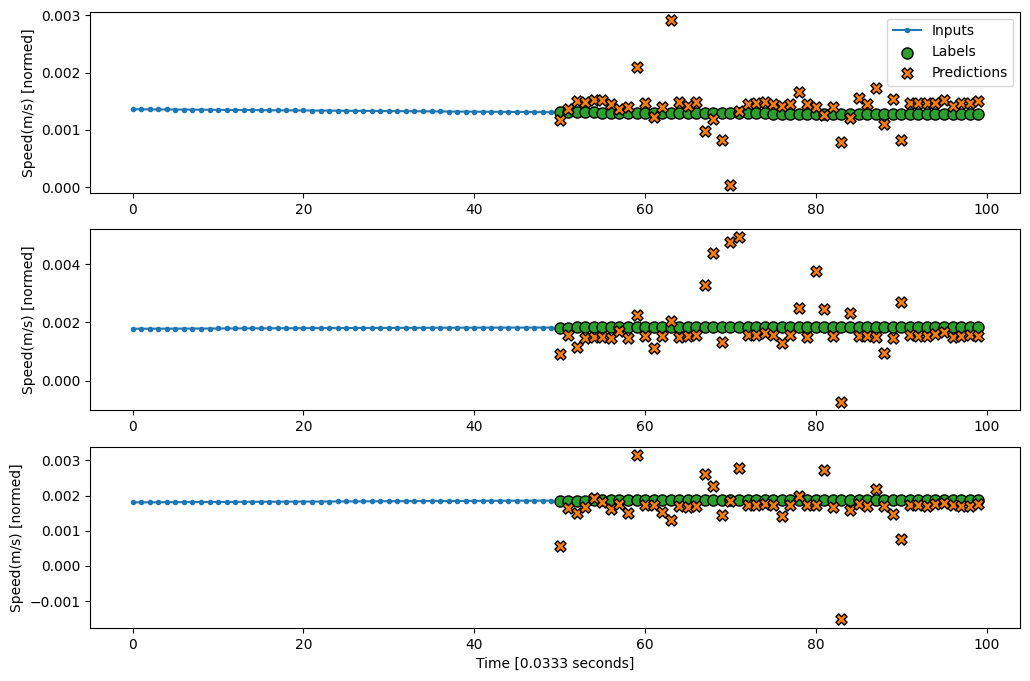

In [19]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps

print(multi_window)

# Create RNN LSTM Model
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape, '\n')

# Train RNN LSTM Model
history = compile_and_fit(multi_lstm_model, multi_window)
# IPython.display.clear_output()

# Evaluate RNN LSTM Model
multi_val_performance['LSTM MW2'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM MW2'] = multi_lstm_model.evaluate(multi_window.test, 
                                                         verbose=0)
print("\nPerformance:", multi_performance['LSTM MW2'], 
      "Val Performance:", multi_val_performance['LSTM MW2'])

# Plot RNN LSTM
multi_window.plot(multi_lstm_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 11)
Output shape: (32, 50, 11) 

Epoch 1/20
32631/32631 [==============================] - 215s 7ms/step - loss: 0.0071 - mean_absolute_error: 0.0468 - val_loss: 0.0049 - val_mean_absolute_error: 0.0333
Epoch 2/20
32631/32631 [==============================] - 214s 7ms/step - loss: 0.0057 - mean_absolute_error: 0.0425 - val_loss: 0.0049 - val_mean_absolute_error: 0.0363
Epoch 3/20
32631/32631 [==============================] - 214s 7ms/step - loss: 0.0056 - mean_absolute_error: 0.0423 - val_loss: 0.0038 - val_mean_absolute_error: 0.0278
Epoch 4/20
32631/32631 [======================

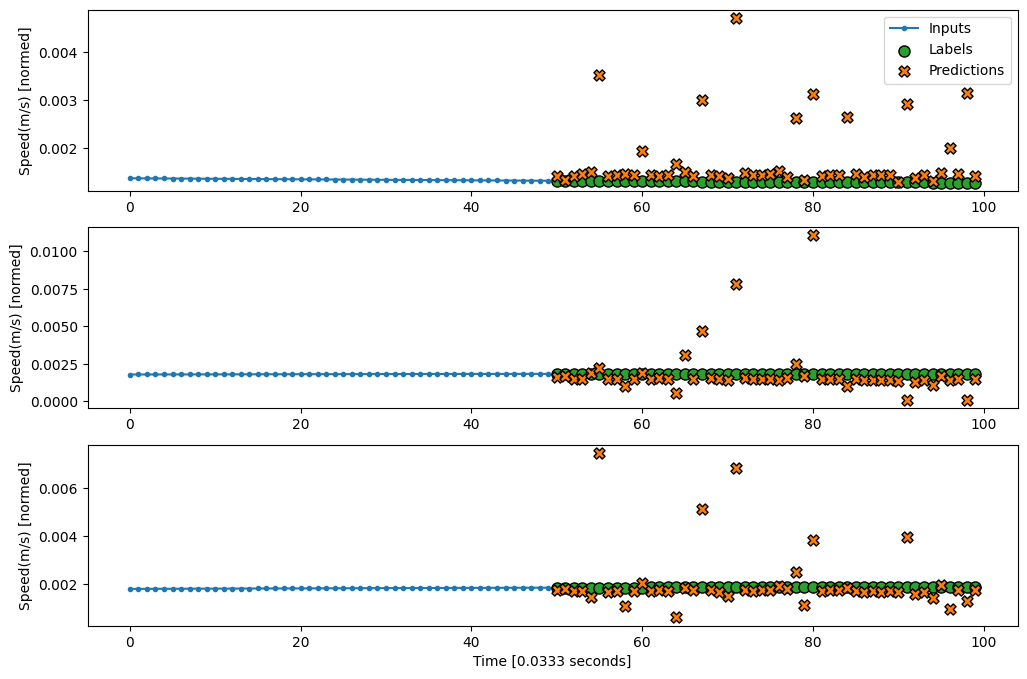

In [20]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps

print(multi_window)

# Create RNN GRU Model
multi_gru_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_gru_model(multi_window.example[0]).shape, '\n')

# Train RNN GRU Model
history = compile_and_fit(multi_gru_model, multi_window)
# IPython.display.clear_output()

# Evaluate RNN GRU Model
multi_val_performance['GRU MW'] = multi_gru_model.evaluate(multi_window.val)
multi_performance['GRU MW'] = multi_gru_model.evaluate(multi_window.test, 
                                                         verbose=0)
print("\nPerformance:", multi_performance['GRU MW'], 
      "Val Performance:", multi_val_performance['GRU MW'])

# Plot RNN GRU
multi_window.plot(multi_gru_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 11)
Output shape: (32, 50, 11) 

Epoch 1/20
32631/32631 [==============================] - 93s 3ms/step - loss: 0.0073 - mean_absolute_error: 0.0473 - val_loss: 0.0044 - val_mean_absolute_error: 0.0322
Epoch 2/20
32631/32631 [==============================] - 91s 3ms/step - loss: 0.0058 - mean_absolute_error: 0.0430 - val_loss: 0.0042 - val_mean_absolute_error: 0.0316
Epoch 3/20
32631/32631 [==============================] - 92s 3ms/step - loss: 0.0057 - mean_absolute_error: 0.0427 - val_loss: 0.0056 - val_mean_absolute_error: 0.0440
Epoch 4/20
9321/9321 [===========================

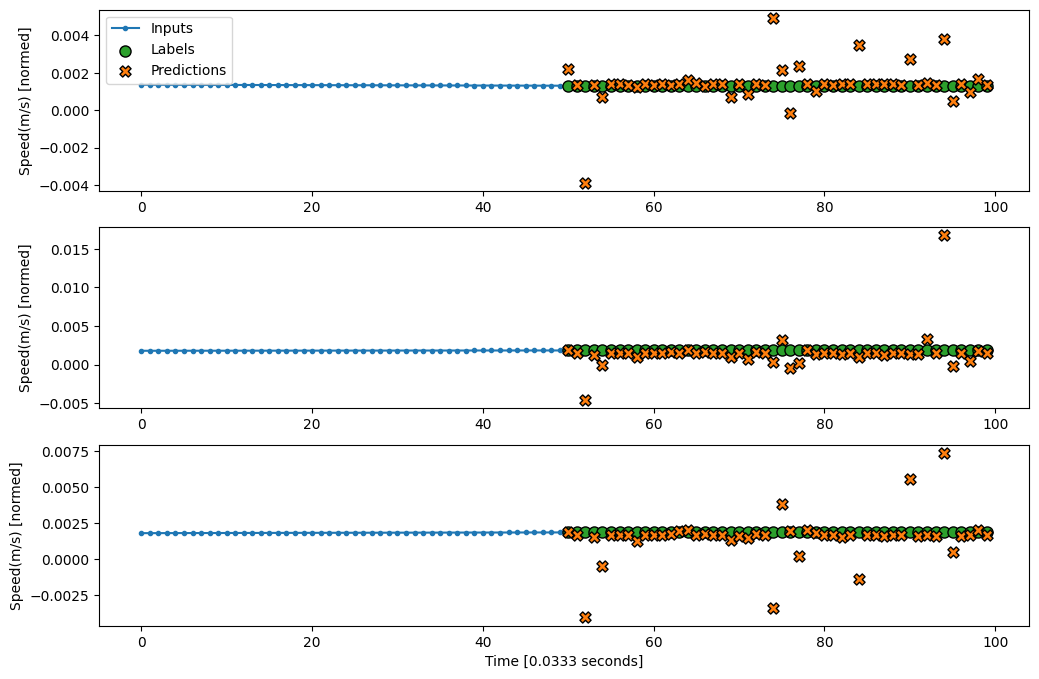

In [21]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps

print(multi_window)

# Create RNN GRU Model
multi_srnn_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.SimpleRNN(32, return_sequences=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_srnn_model(multi_window.example[0]).shape, '\n')

# Train RNN GRU Model
history = compile_and_fit(multi_srnn_model, multi_window)
# IPython.display.clear_output()

# Evaluate RNN GRU Model
multi_val_performance['SIMPLE MW'] = multi_srnn_model.evaluate(multi_window.val)
multi_performance['SIMPLE MW'] = multi_srnn_model.evaluate(multi_window.test, 
                                                         verbose=0)
print("\nPerformance:", multi_performance['SIMPLE MW'], 
      "Val Performance:", multi_val_performance['SIMPLE MW'])

# Plot RNN GRU
multi_window.plot(multi_srnn_model)

Total window size: 100
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Label indices: [50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
Label column name(s): None

Input shape: (32, 50, 11)
Output shape: (32, 50, 11) 

Epoch 1/20
32631/32631 [==============================] - 258s 8ms/step - loss: 0.0061 - mean_absolute_error: 0.0423 - val_loss: 0.0038 - val_mean_absolute_error: 0.0248
Epoch 2/20
32631/32631 [==============================] - 263s 8ms/step - loss: 0.0048 - mean_absolute_error: 0.0379 - val_loss: 0.0034 - val_mean_absolute_error: 0.0196
Epoch 3/20
32631/32631 [==============================] - 276s 8ms/step - loss: 0.0045 - mean_absolute_error: 0.0371 - val_loss: 0.0032 - val_mean_absolute_error: 0.0240
Epoch 4/20
32631/32631 [======================

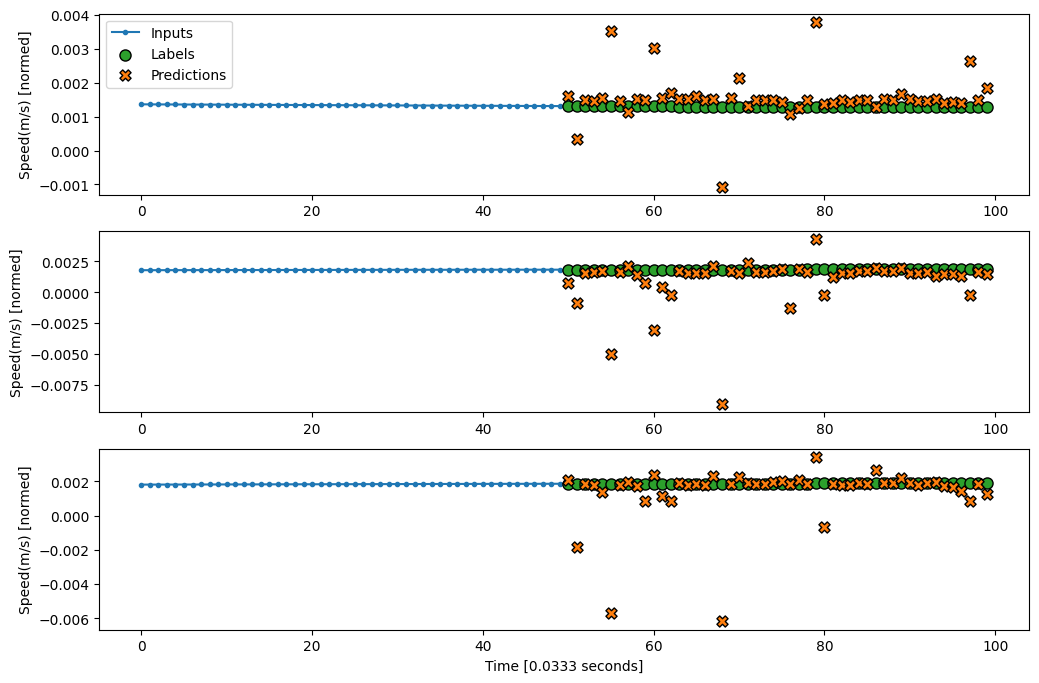

In [22]:
# Recurrent Neural Network
# Learns to use long history of inputs if relevant to predictions
# Accumulates 50 time steps before making a single prediction for 50 time steps

print(multi_window)

# Create RNN GRU Model
multi_bi_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])])

print('\nInput shape:', multi_window.example[0].shape)
print('Output shape:', multi_bi_model(multi_window.example[0]).shape, '\n')

# Train RNN GRU Model
history = compile_and_fit(multi_bi_model, multi_window)
# IPython.display.clear_output()

# Evaluate RNN GRU Model
multi_val_performance['BI MW'] = multi_bi_model.evaluate(multi_window.val)
multi_performance['BI MW'] = multi_bi_model.evaluate(multi_window.test, 
                                                         verbose=0)
print("\nPerformance:", multi_performance['BI MW'], 
      "Val Performance:", multi_val_performance['BI MW'])

# Plot RNN GRU
multi_window.plot(multi_bi_model)

LSTM MW2: 0.0546
GRU MW  : 0.0750
SIMPLE MW: 0.0558
BI MW   : 0.0300


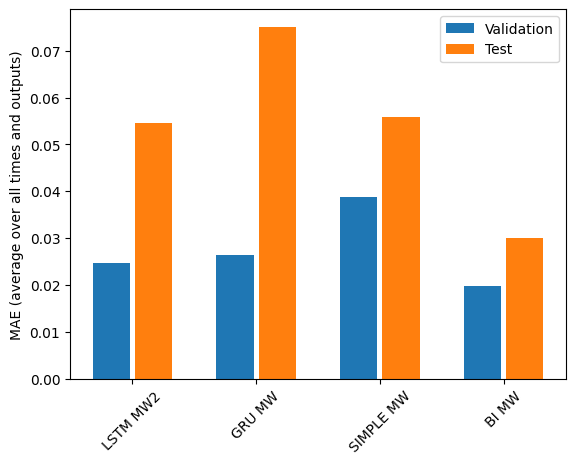

In [23]:
# Display performance of multi step models
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

# Make sure keys are aligned between multi_performance and multi_val_performance
val_mae = [multi_val_performance[k][metric_index] for k in multi_performance.keys()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')